In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

# See dkl_mnist.ipynb for explanation of this flag
gpytorch.functions.use_toeplitz = False

# Make plots inline
%matplotlib inline

In [2]:
# Train points ever 1/999 in [0,1]
train_x = Variable(torch.linspace(0, 1, 1000))
# Function to model is sin(4*pi*x)
# Gaussian noise from N(0,0.04)
train_y = Variable(torch.sin(train_x.data * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2)
train_x = train_x.cuda()
train_y = train_y.cuda()

In [3]:
# We use exact GP inference for regression
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        # Put a grid interpolation kernel over the RBF kernel
        self.base_covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.covar_module = GridInterpolationKernel(self.base_covar_module, grid_size=256,
                                                            grid_bounds=[(0, 1)])
        # Register kernel lengthscale as parameter
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return GaussianRandomVariable(mean_x, covar_x)

# The likelihood output is a Gaussian with predictive mean and variance
likelihood = GaussianLikelihood().cuda()
# Initialize our model
model = GPRegressionModel(train_x.data, train_y.data, likelihood).cuda()

In [4]:
# Optimize the model
model.train()
likelihood.train()

# Adam optimizer on both the model and likelihood parametres
optimizer = optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)
optimizer.n_iter = 0
training_iterations = 20
def train():
    for i in range(training_iterations):
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calc loss and backprop derivatives
        loss = -model.marginal_log_likelihood(likelihood, output, train_y)
        loss.backward()
        optimizer.n_iter += 1
        print('Iter %d/%d - Loss: %.3f' % (i + 1,
                                           training_iterations,
                                           loss.data[0]))
        optimizer.step()
%time train()

Iter 1/20 - Loss: 1.145
Iter 2/20 - Loss: 1.086
Iter 3/20 - Loss: 1.032
Iter 4/20 - Loss: 0.985
Iter 5/20 - Loss: 0.950
Iter 6/20 - Loss: 0.927
Iter 7/20 - Loss: 0.911
Iter 8/20 - Loss: 0.896
Iter 9/20 - Loss: 0.875
Iter 10/20 - Loss: 0.841
Iter 11/20 - Loss: 0.790
Iter 12/20 - Loss: 0.717
Iter 13/20 - Loss: 0.637
Iter 14/20 - Loss: 0.514
Iter 15/20 - Loss: 0.392
Iter 16/20 - Loss: 0.273
Iter 17/20 - Loss: 0.151
Iter 18/20 - Loss: 0.050
Iter 19/20 - Loss: -0.032
Iter 20/20 - Loss: -0.088
CPU times: user 3.45 s, sys: 348 ms, total: 3.8 s
Wall time: 4.1 s


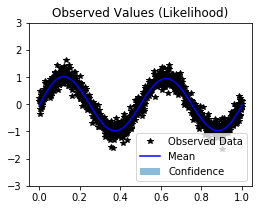

In [5]:
# Set the max number of iterations the the lanczos algorithm is allowed 
# to tridiagonalize  ## WHICH MATRIX ARE WE DOING THIS TO AGAIN? K?
# See gpytorch.utils.lanczos
# https://en.wikipedia.org/wiki/Lanczos_algorithm#Application_to_tridiagonalization
gpytorch.functions.max_lanczos_iterations = 100

# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plot
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
# Test points every 0.02 from 0 to 1 inclusive
test_x = Variable(torch.linspace(0, 1, 51)).cuda()
# Make predictions   ## Why is this set up using with?
with gpytorch.fast_pred_var():
    observed_pred = likelihood(model(test_x))

# Plotting function
def ax_plot(ax, rand_var, title):
    # Get lower and upper confidence bounds
    lower, upper = rand_var.confidence_region()
    # Plot train data as black stars
    ax.plot(train_x.data.cpu().numpy(), train_y.data.cpu().numpy(), 'k*')
    # Plot test data as blue line
    ax.plot(test_x.data.cpu().numpy(), rand_var.mean().data.cpu().numpy(), 'b')
    # Shade in between upper and lower bounds
    ax.fill_between(test_x.data.cpu().numpy(),
                    lower.data.cpu().numpy(), upper.data.cpu().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

#Plot
ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')